In [53]:
import pandas as pd
import copy
from CatalogDataReader import CatalogDataReader
from DataConverter import DataConverter
from TelemetryDataReader import TelemetryDataReader

MAIN_SPORT_DOCUMENT_FILE_PATH = 'SPORT_documents//sport_ttc_20220814.ods'

telemetry_reader = TelemetryDataReader()
catalog_data = CatalogDataReader()
data_converter = DataConverter()

main_tm_df = catalog_data.get_all_tms_on_the_document(MAIN_SPORT_DOCUMENT_FILE_PATH)
main_dd_df = catalog_data.get_all_dds_from_document(MAIN_SPORT_DOCUMENT_FILE_PATH)

telemetry_file_path = 'decoded_satcs_dump\\hk_vur_inst_only.out'
df = telemetry_reader.get_space_packets_df_from_file(telemetry_file_path)

In [54]:
formats_to_implement = []
def calculate_data_conversion(apid:str, binary_data: int, main_dd_df: pd.DataFrame):

    new_data_packets = copy.deepcopy(main_dd_df.query(f"""apid == '{apid}'""")['data_packets'].item())
    pointer = 0
    for single_data_field in new_data_packets:
        bit_length = single_data_field['lenght(bits)']
        if (bit_length is None) or (bit_length == 'N/A'):
            bit_length = 0
        elif bit_length >= len(binary_data) or single_data_field['field'] == 'Total':
            break
        else:
            bit_length = int(bit_length)
    
        binary_slice = binary_data[pointer:(pointer+bit_length)]
        
        assert len(binary_slice) == bit_length, f"{single_data_field}"
        
        data_format = single_data_field['format']
        try:
            transformed_value = data_converter.binary_to_value(binary_slice, data_format, single_data_field['conversion'])
        except ValueError:
            print(f"Implement this format: {data_format} - {binary_slice}")
            if data_format not in formats_to_implement:
                formats_to_implement.append(data_format)
            transformed_value = None

        single_data_field['value'] = transformed_value
        pointer += bit_length

    return new_data_packets

new_fields = []
for i in range(0, len(df)):
    apid = df.iloc[i,:]['apid']
    binary_data = df.iloc[i,:]['data']
    
    new_fields.append(calculate_data_conversion(apid, binary_data, main_dd_df))

assert len(df) == len(new_fields)

df['data_transformed'] = new_fields


In [55]:


y = []
field_id = 2

teste_df = df.query("""apid == '0x8'""").copy()

for i in range(0, len(teste_df)):
    field_data = (teste_df.iloc[i, :]['data_transformed'])[field_id]
    field_name = field_data['field']
    field_unit = field_data['unit']
    observation = field_data['observation']
    y.append(field_data['value'])

new_df = teste_df['secondary_header'].reset_index().copy()
print(observation)
new_df[f"{field_name} ({field_unit})"] = y
new_df = new_df.rename(columns={'secondary_header':'time'})
new_df = new_df.drop(columns='index').set_index('time')

new_df#.loc['2023-01-01':].plot()

None


,Instantaneous RSSI (dBm)
time,
1980-01-06 08:24:22.489,-82.19
2023-09-27 11:27:25.489,-79.76
2023-09-27 11:27:55.489,-84.68
2023-09-27 11:28:25.489,-89.63
2023-09-27 11:28:55.486,-91.28
2023-09-27 11:29:25.486,-82.64
2023-09-27 11:29:55.486,-84.77
2023-09-27 11:30:25.486,-80.00
2023-09-27 11:30:55.487,-78.59


In [56]:
available_apids = df['apid'].unique()

apid_df_dict = dict()
for apid in df['apid'].unique():
    apid_linked_dd = main_dd_df.query(f"""apid == '{apid}'""")['data_packets'].item()
    inner_df = df.query(f"""apid == '{apid}'""").copy(deep=True)
    
    new_df = inner_df['secondary_header'].reset_index().copy(deep=True)
    for field_id in range(0, len(apid_linked_dd)):
        y_aux = []
        for i in range(0, len(inner_df)):
            field_data = (inner_df.iloc[i, :]['data_transformed'])[field_id]

            field_name = field_data['field']
            field_unit = field_data['unit']
            #observation = field_data['observation']
            # print(field_data['value'])
            if 'value' in field_data.keys():
                y_aux.append(field_data['value'])
        if field_name != 'Total':
            new_df[f"{field_name} ({field_unit}) {field_id}"] = y_aux


    new_df = new_df.rename(columns={'secondary_header':'time'})
    new_df = new_df.drop(columns='index').set_index('time')

    apid_df_dict[apid] = new_df

    


In [64]:
main_dd_df.query(f"""apid == '0x8'""")['data_packets'].item()

[{'field': 'Periodic instantaneous RX telemetry:',
  'lenght(bits)': None,
  'format': None,
  'nominal_minimum': None,
  'nominal_maximum': None,
  'conversion': None,
  'unit': None,
  'observation': None},
 {'field': 'Instantaneous Doppler offset',
  'lenght(bits)': 16.0,
  'format': '12-bit ADC',
  'nominal_minimum': 'N/A',
  'nominal_maximum': 'N/A',
  'conversion': 'adc*13.352-22300',
  'unit': 'Hz',
  'observation': None},
 {'field': 'Instantaneous RSSI',
  'lenght(bits)': 16.0,
  'format': '12-bit ADC',
  'nominal_minimum': 'N/A',
  'nominal_maximum': 'N/A',
  'conversion': 'adc*0.03–152',
  'unit': 'dBm',
  'observation': None},
 {'field': 'Power bus voltage',
  'lenght(bits)': 16.0,
  'format': '12-bit ADC',
  'nominal_minimum': 'N/A',
  'nominal_maximum': 'N/A',
  'conversion': 'adc*0.00488',
  'unit': 'V',
  'observation': None},
 {'field': 'Total supply current',
  'lenght(bits)': 16.0,
  'format': '12-bit ADC',
  'nominal_minimum': 'N/A',
  'nominal_maximum': 'N/A',
  'co

In [69]:
possible_fields = []
for i, dict in enumerate(main_dd_df.query(f"""apid == '0x8'""")['data_packets'].item()):
    field = dict['field']
    unit = dict['unit']
    if field == 'Total':
        break
    possible_fields.append(f"{field} ({unit}) {i}")
    print(f"{field} ({unit}) {i}")

possible_fields

Periodic instantaneous RX telemetry: (None) 0
Instantaneous Doppler offset (Hz) 1
Instantaneous RSSI (dBm) 2
Power bus voltage (V) 3
Total supply current (mA) 4
Transmitter current (mA) 5
Receiver current (mA) 6
Power amplifier current (mA) 7
Power amplifier temperature (°C) 8
Local oscillator temperature (°C) 9
Periodic last transmission TX telemetry: (None) 10
Instantaneous RF reflected power (dBm) 11
Instantaneous RF forward power (dBm) 12
Power bus voltage (V) 13
Total supply current (mA) 14
Transmitter current (mA) 15
Receiver current (mA) 16
Power amplifier current (mA) 17
Power amplifier temperature (°C) 18
Local oscillator temperature (°C) 19


['Periodic instantaneous RX telemetry: (None) 0',
 'Instantaneous Doppler offset (Hz) 1',
 'Instantaneous RSSI (dBm) 2',
 'Power bus voltage (V) 3',
 'Total supply current (mA) 4',
 'Transmitter current (mA) 5',
 'Receiver current (mA) 6',
 'Power amplifier current (mA) 7',
 'Power amplifier temperature (°C) 8',
 'Local oscillator temperature (°C) 9',
 'Periodic last transmission TX telemetry: (None) 10',
 'Instantaneous RF reflected power (dBm) 11',
 'Instantaneous RF forward power (dBm) 12',
 'Power bus voltage (V) 13',
 'Total supply current (mA) 14',
 'Transmitter current (mA) 15',
 'Receiver current (mA) 16',
 'Power amplifier current (mA) 17',
 'Power amplifier temperature (°C) 18',
 'Local oscillator temperature (°C) 19']

In [62]:
apid_df_dict['0x8']

,Periodic instantaneous RX telemetry: (None) 0,Instantaneous Doppler offset (Hz) 1,Instantaneous RSSI (dBm) 2,Power bus voltage (V) 3,Total supply current (mA) 4,Transmitter current (mA) 5,Receiver current (mA) 6,Power amplifier current (mA) 7,Power amplifier temperature (°C) 8,Local oscillator temperature (°C) 9,Periodic last transmission TX telemetry: (None) 10,Instantaneous RF reflected power (dBm) 11,Instantaneous RF forward power (dBm) 12,Power bus voltage (V) 13,Total supply current (mA) 14,Transmitter current (mA) 15,Receiver current (mA) 16,Power amplifier current (mA) 17,Power amplifier temperature (°C) 18,Local oscillator temperature (°C) 19
time,,,,,,,,,,,,,,,,,,,,
1980-01-06 08:24:22.489,None,10078.600,-82.19,8.07152,49.599013,12.649413,98.032948,0.166440,10.62742,8.63348,None,29.342927,717.864548,7.88608,402.950368,160.281373,98.365827,418.096376,10.55073,8.48010
2023-09-27 11:27:25.489,None,8302.784,-79.76,7.37368,53.593564,12.815852,97.700069,0.166440,10.85749,8.78686,None,31.285932,709.665134,8.12032,399.621576,159.948494,98.532267,403.949006,10.70411,8.63348
2023-09-27 11:27:55.489,None,8916.976,-84.68,8.05688,49.266133,12.316533,98.365827,0.166440,11.01087,8.94024,None,31.114502,722.394300,7.93976,390.800275,160.114934,98.032948,408.942195,10.93418,8.71017
2023-09-27 11:28:25.489,None,4671.040,-89.63,7.93000,204.221438,157.451899,99.364465,190.074069,11.16425,9.01693,None,30.348898,693.811737,7.86168,392.131792,160.447813,98.199388,410.107273,11.16425,8.86355
2023-09-27 11:28:55.486,None,1626.784,-91.28,7.26632,440.066408,158.949856,99.031586,427.084116,12.39129,9.17031,None,29.259862,719.098522,7.27120,427.250556,158.783417,98.698707,412.104549,12.23791,9.01693
2023-09-27 11:29:25.486,None,10385.696,-82.64,7.89584,401.452412,158.783417,98.199388,443.228761,14.84537,9.86052,None,30.095816,751.133162,7.90560,392.797550,158.949856,98.698707,421.425168,14.69199,9.70714
2023-09-27 11:29:55.486,None,7701.944,-84.77,7.90072,406.778480,158.949856,98.532267,407.277799,16.07241,10.55073,None,29.342927,712.120013,7.96416,395.127705,159.282735,98.865146,409.441514,15.99572,10.47404
2023-09-27 11:30:25.486,None,7101.104,-80.00,7.25656,430.412909,158.949856,98.199388,432.909504,17.06938,11.24094,None,29.509412,714.168983,7.25168,431.245107,159.116296,98.365827,410.939471,16.91600,11.08756
2023-09-27 11:30:55.487,None,8022.392,-78.59,7.98368,384.974887,159.116296,98.032948,416.431979,17.91297,11.85446,None,29.342927,712.939248,7.97392,391.632473,159.449175,98.199388,421.258729,17.68290,11.70108


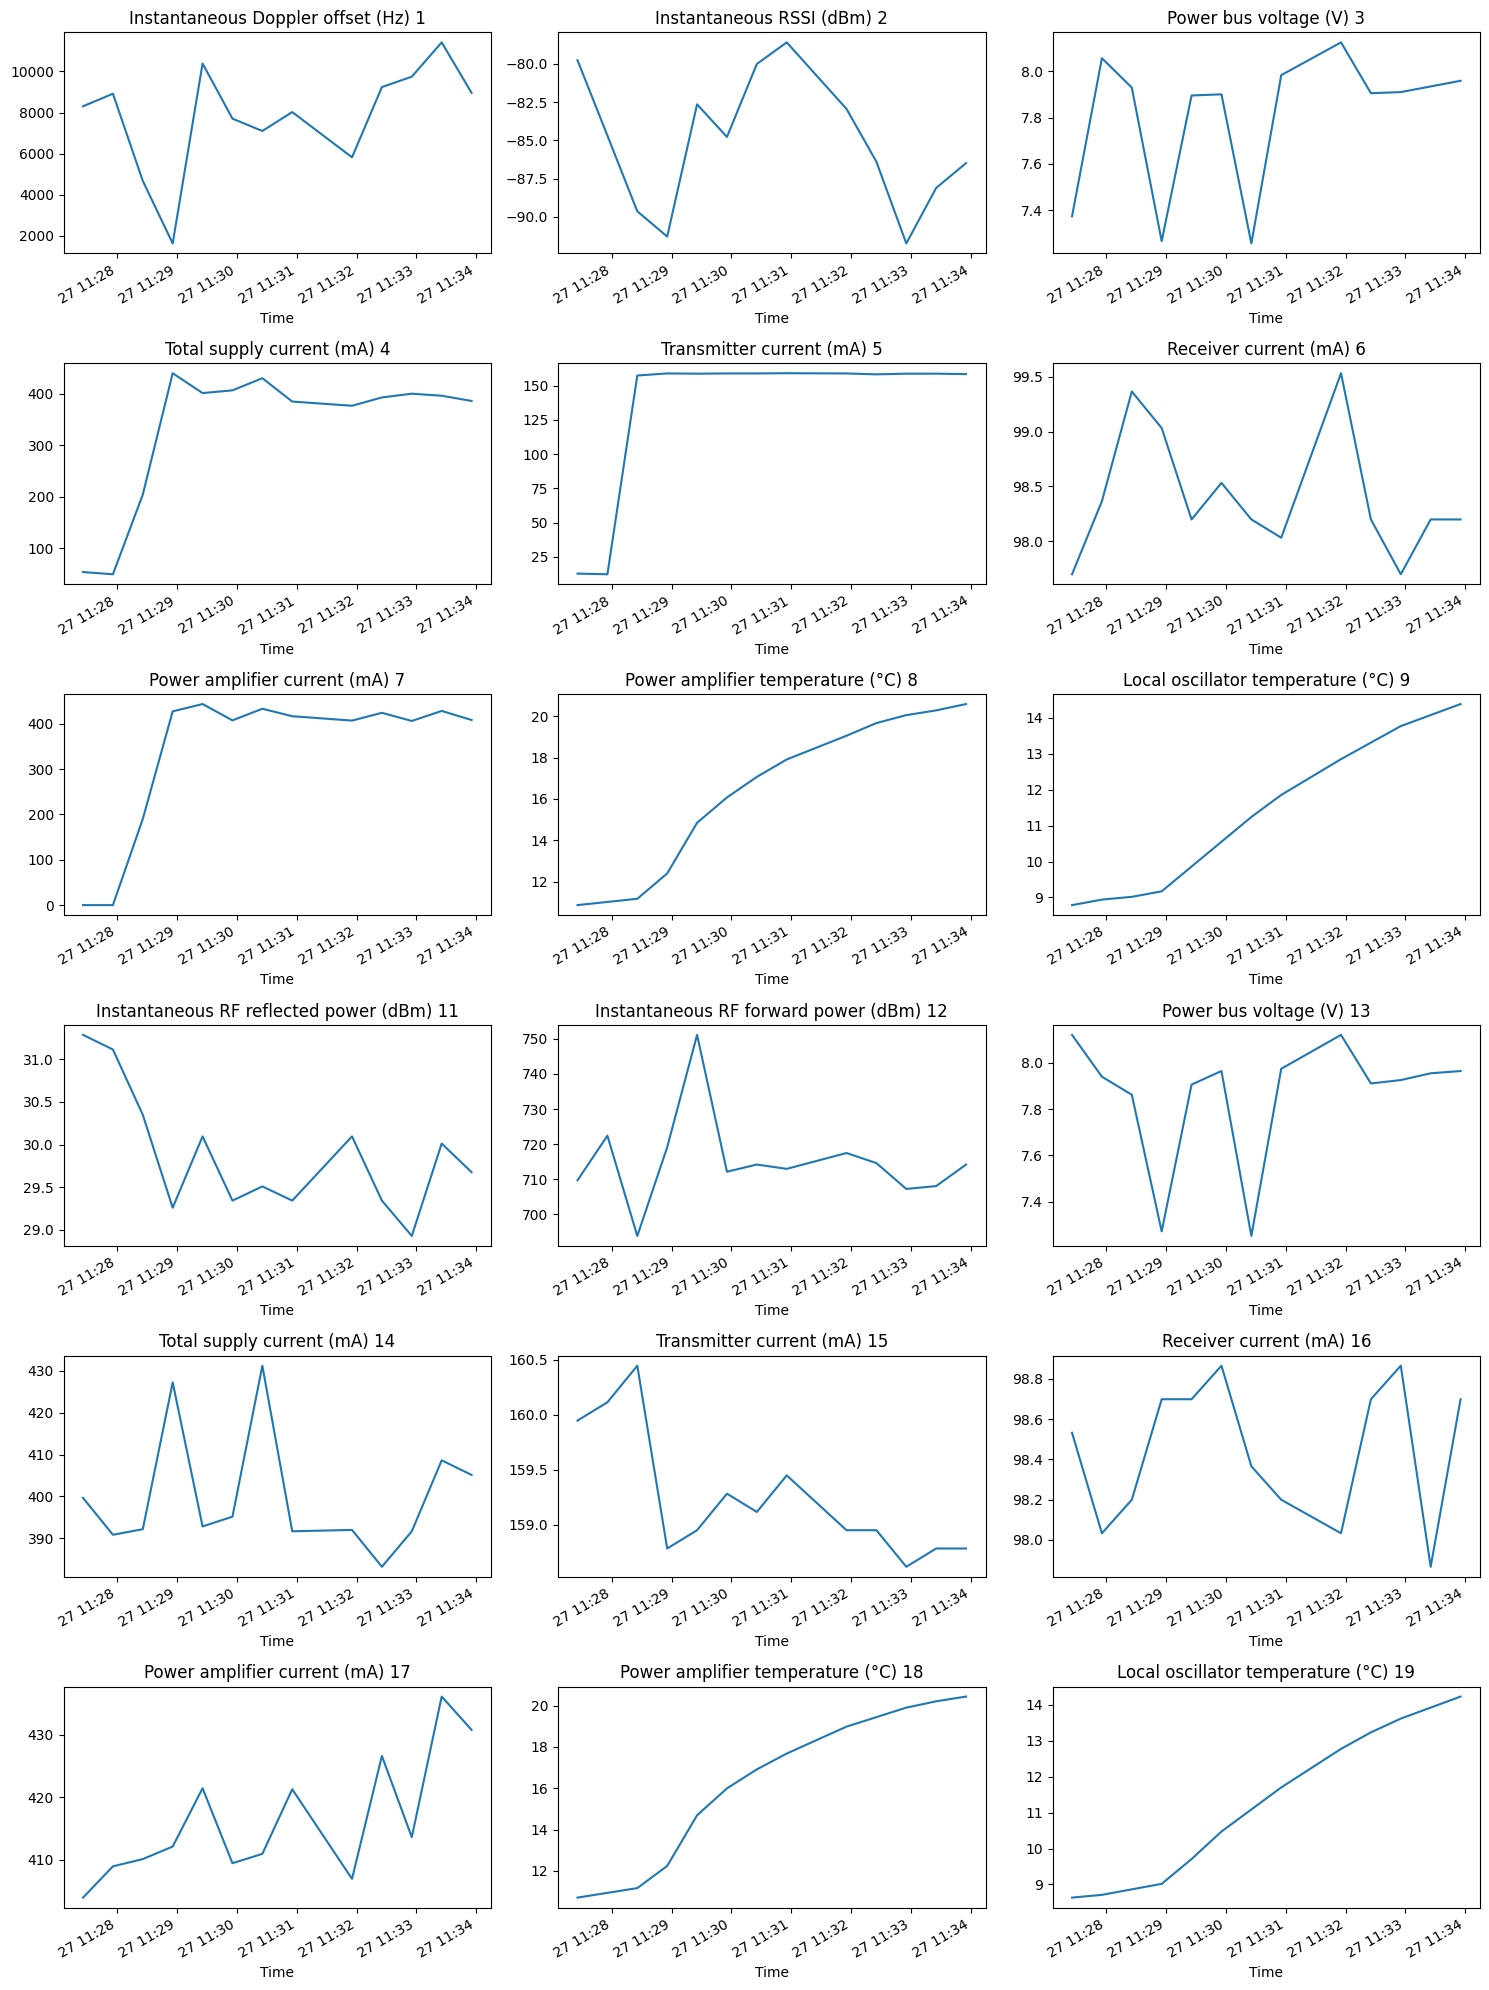

In [58]:
from matplotlib import pyplot as plt


plot_df = apid_df_dict['0x8'].loc['2020-01-01':].dropna(axis=1)

# Calculate number of rows needed for two columns
n_columns = 3
n_rows = -(-len(plot_df.columns) // n_columns)  # This is a ceiling division

# Create subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, 20))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for ax, column in zip(axs, plot_df.columns):
    plot_df[column].plot(ax=ax, title=column)
    ax.set_xlabel('Time')
    # ax.set_ylabel(column)

# Hide any empty subplots
for ax in axs[len(plot_df.columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()